# **Image captioning on COCO dataset.**



Etienne Sullice & Charles Laroche

## **Cloning with GitHub repository of the project**

In [2]:
!git clone https://github.com/CharlesLaroche/NLP_project.git

Cloning into 'NLP_project'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14 (delta 2), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


## **Data downloading**

In [0]:
!rm sample_data/README.md sample_data/anscombe.json sample_data/california_housing_test.csv
!rm sample_data/california_housing_train.csv sample_data/mnist_test.csv sample_data/mnist_train_small.csv

In [3]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -qq train2017.zip
!rm train2017.zip

--2020-04-10 16:57:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.112.235
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.112.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  47.5MB/s    in 7m 33s  

2020-04-10 17:05:12 (40.7 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



We save only 10000 images to limit the space used on the disc and to make our training faster

In [0]:
!find /content/train2017 -type f -print0 | sort -zR | tail -zn +10001 | xargs -0 rm

In [5]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!rm annotations/instances_train2017.json annotations/instances_val2017.json
!rm annotations/person_keypoints_train2017.json annotations/person_keypoints_val2017.json 

--2020-04-10 17:14:36--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.10.180
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.10.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  49.3MB/s    in 5.2s    

2020-04-10 17:14:41 (46.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


## **Dropbox linking to access the weights**

I linked my dropbox to save the weights and train the model step by step using checkpoints, the Dropbox app will be shut down around one month after the project so you wont be able to access the weights after this date.

In [6]:
!git clone https://github.com/thatbrguy/Dropbox-Uploader.git
!chmod +x /content/Dropbox-Uploader/dropbox_uploader.sh
!bash /content/Dropbox-Uploader/dropbox_uploader.sh
!echo 4WBdlmB_KcAAAAAAAAAAKfmZzAzVBJjHRMUKbZupy4nM_c-0m2_h7E93C5TbsjGi > token.txt
!bash /content/Dropbox-Uploader/dropbox_uploader.sh

Cloning into 'Dropbox-Uploader'...
remote: Enumerating objects: 951, done.
remote: Total 951 (delta 0), reused 0 (delta 0), pack-reused 951
Receiving objects: 100% (951/951), 309.19 KiB | 1018.00 KiB/s, done.
Resolving deltas: 100% (505/505), done.

 This is the first time you run this script, please follow the instructions:

 1) Open the following URL in your Browser, and log in using your account: https://www.dropbox.com/developers/apps
 2) Click on "Create App", then select "Dropbox API app"
 3) Now go on with the configuration, choosing the app permissions and access restrictions to your DropBox folder
 4) Enter the "App Name" that you prefer (e.g. MyUploader69322969824606)

 Now, click on the "Create App" button.

 When your new App is successfully created, please click on the Generate button
 under the 'Generated access token' section, then execute the following command:

 echo "INPUT_YOUR_ACCESS_TOKEN_HERE" > token.txt


 This is the first time you run this script, please follow

## **Import dependancies**

In [0]:
import os
import pickle
import time
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from nltk.translate.bleu_score import corpus_bleu
from NLP_project.networks import Encoder, DecoderWithAttention, Attention
from NLP_project.beam_s import caption_image_beam_search
from NLP_project.visualize import visualize_att
from NLP_project.utils import plot_torch_img, opposite_split, AverageMeter, adjust_learning_rate
from NLP_project.utils import accuracy, save_checkpoint, clip_gradient
from NLP_project.dataset import EncodeCaption, CocoDataset

In [0]:
IMG_PATH = '/content/train2017/'
img_paths = [os.path.join(IMG_PATH, i) for i in os.listdir(IMG_PATH)]
ANOT_PATH = '/content/annotations/captions_train2017.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Data exploration and pre-processing on the captions**

In [0]:
with open(ANOT_PATH) as f:
    d = json.load(f)['annotations']

Quick pre-processing to remove dots and spaces (also done in CocoDataset)

In [0]:
captions_processed = {}
for dico in d:
    cap = dico['caption'].lower().split()
    if cap[-1] == ' ':
        cap = cap[:-1]
        
    if cap[-1][-1] == '.':
        cap[-1] = cap[-1][:-1]

    try:
        captions_processed[dico['image_id']].append(cap)
    except:
        captions_processed[dico['image_id']] = [cap]

Test of the encoder

In [35]:
class_ = EncodeCaption(captions_processed)
print("Pre-processed caption:", opposite_split(class_.captions[390241][0]))
encoded_cap, length = class_.encode_word(class_.captions[390241][0])
print("Encoded caption length:", length)
print("Encoded caption:", encoded_cap)

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Pre-processed caption: a white train car lays on its side in the dark while a man with a light is nearby
Encoded caption length: 21
Encoded caption: [3.6301e+04 1.0000e+00 2.7000e+01 5.1600e+02 4.6000e+01 2.5430e+03
 3.7000e+01 3.9700e+02 1.7900e+02 1.7000e+01 7.0000e+00 1.2170e+03
 4.2100e+02 1.0000e+00 2.1600e+02 4.0000e+00 1.0000e+00 4.9500e+02
 1.9000e+01 1.3740e+03 3.6302e+04 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.000

## **Data vizualization**

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


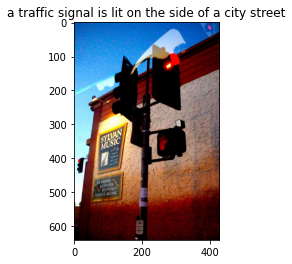

Caption length: tensor([14])


In [36]:
data = CocoDataset(IMG_PATH, ANOT_PATH, transform = transforms.ToTensor(), 
                   target_transform = lambda x: torch.Tensor(x))

test_data = data[0]
plot_torch_img(opposite_split(test_data[1]), test_data[0])
print("Caption length:", test_data[-2])

## **Training**

In [0]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    """ Performs one epoch's training.
        Params
            train_loader: DataLoader for training data
            encoder: encoder model
            decoder: decoder model
            criterion: loss layer
            encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
            decoder_optimizer: optimizer to update decoder's weights
            epoch: epoch number
    """
    global device

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss (per word decoded)
    top5accs = AverageMeter()  # top5 accuracy

    start = time.time()

    # Batches
    for i, (imgs, _, caps, caplens, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores, _, _, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

## **Validation with BLUE**

In [0]:
def validate(val_loader, encoder, decoder, criterion, word_map):
    """Performs one epoch's validation.
       Params:
          val_loader: DataLoader for validation data.
          encoder: encoder model
          decoder: decoder model
          criterion: loss layer
       Returns: 
          BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    # solves the issue #57
    with torch.no_grad():
        # Batches
        for i, (imgs, _, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)

            # Forward prop.
            if encoder is not None:
                imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove timesteps that we didn't decode at, or are pads
            # pack_padded_sequence is an easy trick to do this
            scores_copy = scores.clone()
            scores, _, _, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets, _, _, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

            # Calculate loss
            loss = criterion(scores, targets)

            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # Keep track of metrics
            losses.update(loss.item(), sum(decode_lengths))
            top5 = accuracy(scores, targets, 5)
            top5accs.update(top5, sum(decode_lengths))
            batch_time.update(time.time() - start)

            start = time.time()

            if i % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                                loss=losses, top5=top5accs))

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for j in range(allcaps.shape[0]):
                img_caps = allcaps[j].tolist()
                img_captions = list(
                    map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, p in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            preds = temp_preds
            hypotheses.extend(preds)

            assert len(references) == len(hypotheses)

        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

        print(
            '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
                loss=losses,
                top5=top5accs,
                bleu=bleu4))

    return bleu4

## **Putting it all together**

In [0]:
def main():
  global best_bleu4, epochs_since_improvement, checkpoint, start_epoch, fine_tune_encoder, device

  data_train = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=True)
  data_val = CocoDataset(IMG_PATH, ANOT_PATH, transform = transformer,
                     target_transform=lambda x: torch.LongTensor(x),
                     data_train=False)
  train_loader = DataLoader(data_train, batch_size=16, shuffle=True, num_workers=1)
  val_loader = DataLoader(data_val, batch_size=16, shuffle=True, num_workers=1)
  max_len = int(data.encoder.max_len)

  word_map = data_train.encoder.word_map

  # Initialize / load checkpoint
  if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim=attention_dim, embed_dim=emb_dim,
                                   decoder_dim=decoder_dim, vocab_size=len(word_map),
                                   dropout=dropout, device=device)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
    encoder = Encoder()
    encoder_optimizer = None

  else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    epochs_since_improvement = checkpoint['epochs_since_improvement']
    best_bleu4 = checkpoint['bleu-4']
    if best_bleu4 is None:
        best_bleu4 = 0
    decoder = checkpoint['decoder']
    decoder.device = device
    decoder_optimizer = checkpoint['decoder_optimizer']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']

  # Move to GPU, if available
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  # Loss function
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(start_epoch, epochs):
      # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
      if epochs_since_improvement == 20:
          break
      if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
          adjust_learning_rate(decoder_optimizer, 0.8)
          if fine_tune_encoder:
              adjust_learning_rate(encoder_optimizer, 0.8)

      # One epoch's training
      train(train_loader=train_loader, encoder=encoder, decoder=decoder,
            criterion=criterion, encoder_optimizer=encoder_optimizer,
            decoder_optimizer=decoder_optimizer, epoch=epoch)
      
      # One epoch's validation
      recent_bleu4 = validate(val_loader=val_loader, encoder=encoder,
                              decoder=decoder, criterion=criterion, word_map=word_map)

      # Check if there was an improvement
      is_best = recent_bleu4 > best_bleu4
      best_bleu4 = max(recent_bleu4, best_bleu4)
      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
      else:
          epochs_since_improvement = 0
      
      # Save checkpoint
      save_checkpoint("coco2017", epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                      decoder_optimizer, best_bleu4, is_best)

In [40]:
# Download the weights from my Dropbox
!bash /content/Dropbox-Uploader/dropbox_uploader.sh download NLP_project/BEST_checkpoint_coco2017.pth.tar

> Skipping file "/NLP_project/BEST_checkpoint_coco2017.pth.tar", file exists with the same hash


In [0]:
# Model parameters
emb_dim = 512  # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
transformer = transforms.Compose([lambda x: x.resize((256,256)), transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])

# Training parameters
start_epoch = 0
epochs = 40  # number of epochs to train for (if early stopping is not triggered)
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU
batch_size = 16
workers = 1  # for data-loading; right now, only 1 works with h5py
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
best_bleu4 = 0.  # BLEU-4 score right now
print_freq = 100  # print training/validation stats every __ batches
checkpoint = "/content/BEST_checkpoint_coco2017.pth.tar"  # path to checkpoint, None if none

In [42]:
main()

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map creation...
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Word_map created!
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Epoch: [34][0/417]	Batch Time 0.938 (0.938)	Data Load Time 0.349 (0.349)	Loss 3.9613 (3.9613)	Top-5 Accuracy 67.04

In [0]:
!bash /content/Dropbox-Uploader/dropbox_uploader.sh upload BEST_checkpoint_coco2017.pth.tar NLP_project/BEST_checkpoint_coco2017.pth.tar

 > Uploading "/content/BEST_checkpoint_coco2017.pth.tar" to "/NLP_project/BEST_checkpoint_coco2017.pth.tar" by 15 chunks ............... DONE


## **Testing and visualization of the results**

In [0]:
checkpoint = torch.load("/content/BEST_checkpoint_coco2017.pth.tar")

decoder = checkpoint['decoder']
encoder = checkpoint['encoder']

img_path = ["/content/train2017/" + i for i in os.listdir("/content/train2017")]
inv_word_map = {x:i for i,x in data.encoder.word_map.items()}

#### **Caption generation**

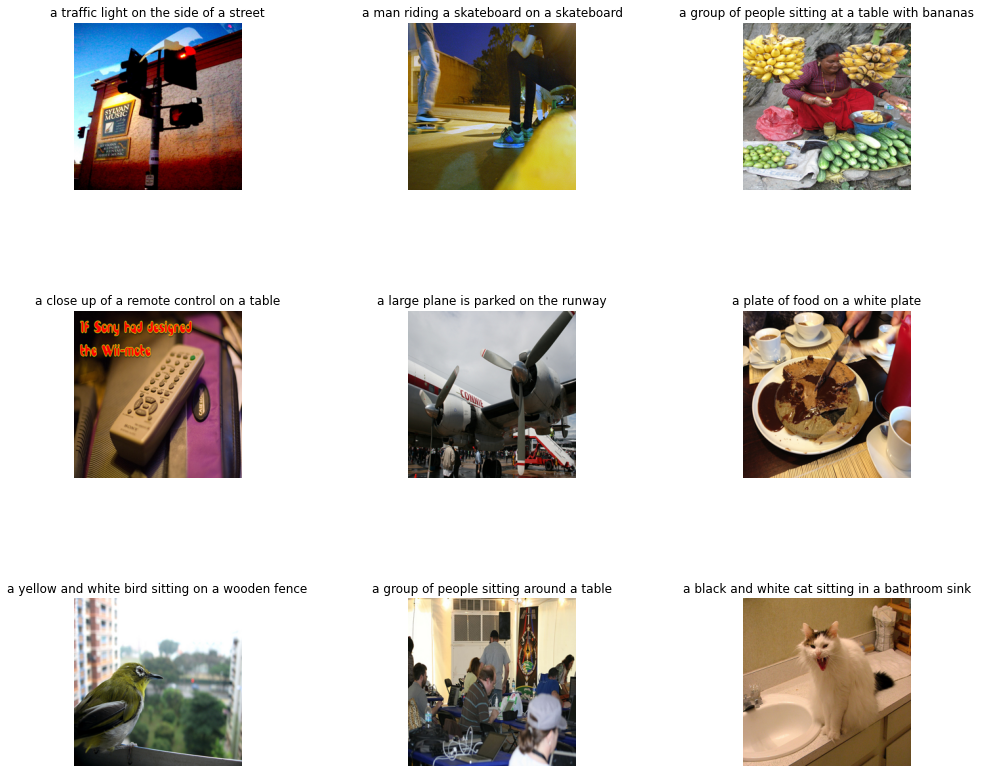

In [44]:
f, axs = plt.subplots(3,3,figsize=(15,15))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

for i in range(9):
  seq, alphas, img = caption_image_beam_search(encoder, decoder, img_path[i],
                                               data.encoder.word_map, device=device,
                                               beam_size=3)
  pred = [inv_word_map[i] for i in seq[1:-1]]
  axs[i % 3,i // 3].imshow(img)
  axs[i % 3,i // 3].set_title(opposite_split(pred))
  axs[i % 3,i // 3].axis('off')
  
plt.savefig("cap_generation_1.jpg")

#### **Attention visualization**

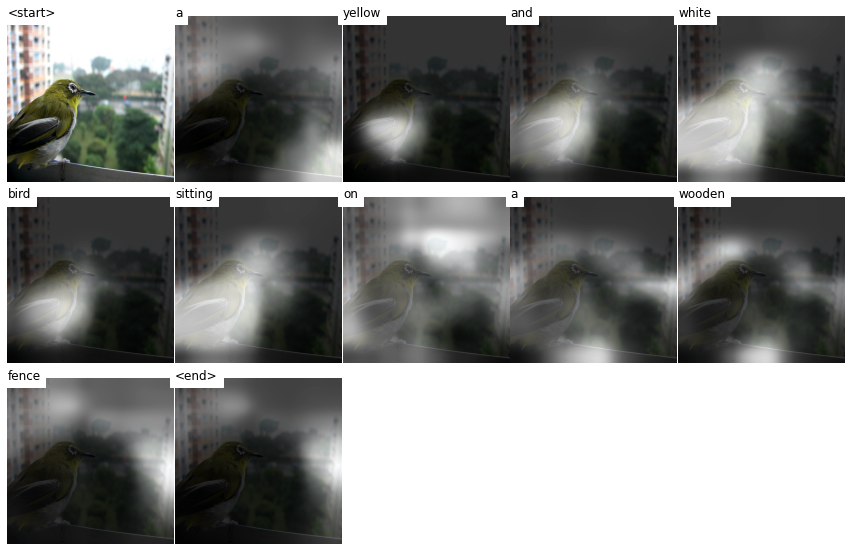

In [46]:
seq, alphas, img = caption_image_beam_search(encoder, decoder, img_path[2] , data.encoder.word_map, device, beam_size=3)
alphas = torch.tensor(alphas)
visualize_att(img_path[2], seq, alphas, inv_word_map, smooth=True)

## **Baseline part**

In [0]:
def generate_ML_data():
    global device, IMG_PATH, ANOT_PATH, transformer

    data_train = cocodataset(IMG_PATH, ANOT_PATH, transform = transformer, data_train=True,
                   target_transform = lambda x: torch.Tensor(x), n_samples=10000)
    data_test = cocodataset(IMG_PATH, ANOT_PATH, transform = transformer, data_train=False,
                   target_transform = lambda x: torch.Tensor(x), n_samples=10000)

    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    encoder =  Encoder()
    encoder.fine_tune(False)
    encoder.to(device)

    for img, _, encoded_ann, _, _ in data_train:
        feat_vect = encoder(img.unsqueeze(0).to(device))
        X_train.append(feat_vect[0].cpu().numpy().flatten())
        Y_train.append(encoded_ann.numpy())

    for img, _, encoded_ann, _, _ in data_test:
        feat_vect = encoder(img.unsqueeze(0).to(device))
        X_test.append(feat_vect[0].cpu().numpy().flatten())
        Y_test.append(encoded_ann.numpy())

    return X_train, Y_train, X_test, Y_test, data_train.encoder.word_map

In [0]:
X_train, Y_train, X_test, Y_test, word_map = generate_ML_data()
import pickle
d = {'X_train': X_train, 'y_train': Y_train, 'X_test': X_test, 'y_test': Y_test, 'word_map':class_.word_map}
with open('word_map.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
#Too heavy.....